<div class="alert alert-block alert-info">
   <h2 align="center"> <center><b> Reinforcement Learning Assignment 7 - Model Based Reinforcement Learning </b></center></h2>

<br>
<center><font size="3">This notebook is a part of teaching material for ELEC-E8125</font></center>
<center><font size="3">Sep 4, 2024 - Nov 30, 2024</font></center>
<center><font size="3">Aalto University</font></center>
</div>


<a id='TOC'></a>

<div class="alert alert-block alert-success">
    
# Table of contents
* <a href='#1.'> 1. Introduction </a>
* <a href='#1.1'> 1.1 Learning Objectives </a>
* <a href='#1.2'> 1.2 Code Structure & Files </a>
* <a href='#2.'> 2. MCTS </a>
* <a href='#3.'> 3. Submitting </a>
* <a href='#3.1'> 3.1 Feedback </a>
* <a href='#4.'> References</a>
    
<a href='#Q1'><b>Student Question 1</b> Difficulty of the task (10 points)</a>\
<a href='#T1'><b>Student Task 1.</b> Implementing MCTS (30 points)</a>\
<a href='#Q2'><b>Student Question 2</b> MCTS phases</a>
    
**Total Points:** 50

**Estimated runtime of all the cells:** 1 hour

# 1. Introduction <a id='1.'></a>
In this section, we will use **Monte Carlo Tree Search (MCTS)** algorithm to solve **DeepSea** environment form [Behaviour Suite for Reinforcement Learning (bsuite)](https://github.com/google-deepmind/bsuite). The environment targets the challenge of exploration and represents a N×N grid where the agent starts in the top left and has to reach a goal in the bottom right location. At each timestep, the agent moves one row down and can choose one out of two actions. The agent observes the current location and receives a small negative reward of -0.01/N  for moving right and 0 reward for moving left. Additionally, the agent receives a reward of +1 for reaching the goal (treasure) and the episode ends after N timesteps. In this exercise, the number of rows and columns (N) is 10. 
<br>

<div style="text-align: center;">
    <img src="imgs/deep_sea.png" width="400px">
    <figcaption> Figure 1: Deep-Sea environment </figcaption>
</div>

## 1.1 Learning Objectives: <a id='1.1'></a>
- Understand different phases of MCTS
- Implement a simplified version of MCTS

## 1.2 Code Structure & Files <a id='1.2'></a>

You don’t have to edit any other file other than ```ex7.ipynb``` to complete this exercise.

```
├───imgs                 # Images used in notebook
│   ex7_MCTS.ipynb       # Main assignment file containing tasks <---------
│   env.py               # Wrappers for the environment
│   simulator.py         # Using the exact environment as the model (simulator)
```

## Warnings:

- Don’t copy and paste cells within a notebook. This will mess up the tracking metadata and prevent autograding from working.
- Only add new cells using the '+' button in the upper toolbar and do not split cells.
- Be cautious about things such as copying the whole notebook to Colab to work on it. This has sometimes resulted in removing all notebook metadata, making autograding impossible.

<a id='Q1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.</b> Difficulty of the task (10 points)</h3> 

<!-- 1.1. What is the probability of reaching the goal state (a function of N) for **DeepSea** environment? <br>
1.2. If N is large, DQN (with the $\epsilon$-greedy policy) usually fail to reach the goal state (in fact, N=10 is already challenging for DQN). In this case, which strategy will DQN converge to? <br> -->
Consider the DeepSea environment with a large N (number of columns and rows). DQN (with the  𝜖-greedy policy) usually fail to reach the goal state (in fact, N=10 is already challenging for DQN). Which statement is correct?
1. DQN will converge to a random policy with a probability of $0.5^{N-1}$ to reach the goal location. 
2. DQN will converge to a policy that always selects left action. The probability of reaching goal for a random agent is $0.5^{N-1}$
3. DQN will converge to a policy that always selects left action, since  $\epsilon$-greedy policy is used, the probability to reach the goal is $\epsilon^{N-1}$. 
4. DQN will converge to a random policy with a probability of $\epsilon^{N-1}$ to reach the goal location. 

🔝	<a href='#TOC'><b>Table of Contents</b></a>
    🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

In [1]:
sq1 = 4  # replace ``None`` with your answer

Do not remove or change the following cells, which are used for grading.

# 2. MCTS <a id='2.'></a>

<a id='T1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 1.</b> Implement MCTS algorithm (30 points) </h3> 

Complete ```TODOs``` in the MCTS class below. Specifically, you need to: <br>
1. finish the implementation of ```select_action``` method that selects the best action given the MCTS node using UCB1 exploration. <br>
2. implement ```simulation``` method where you need to use best action to select the next node and expansion procedure of MCTS when there are no children.
3. complete ```backpropagation``` method that updates the attributes of each node in the trajectory. <br>

**Ensure that the notebook contains the average return plot.**

The reference training plot is as Figure 2 (your plot might look different):
<div style="text-align: center;">
    <img src="imgs/mcts_avg_return.png">
    <figcaption> Figure 2: Average episode return for MCTS on DeepSea environment </figcaption>
</div>
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

In [40]:
skip_training = True  # Set this flag to True before validation and submission

In [3]:
import bsuite
import gym
import numpy as np
import matplotlib.pyplot as plt
from env import BsuiteToGymWrapper

In [4]:
##### MCTS #####
class Node(object):
    """ A MCTS Node. """
    def __init__(self):
        self.reward: float = 0.
        self.visit_count: int = 0
        self.done: bool = False
        self.total_value: float = 0.  # cumulative value
        self.children: dict = {}  # children nodes, index is the action

    def expand(self, num_action: int):
        """ Expands this node by adding cild nodes. """
        for action in range(num_action):
            self.children[action] = Node()
    
    @property
    def value(self):  # Q(s, a)
        """Returns the value of this node."""
        if self.visit_count:
            return self.total_value / self.visit_count
        return 0.

    @property
    def children_visits(self) -> np.ndarray:
        """Return array of visit counts of visited children."""
        return np.array([c.visit_count for c in self.children.values()])

    @property
    def children_values(self) -> np.ndarray:
        """Return array of values of visited children."""
        return np.array([c.value for c in self.children.values()])

In [34]:
class MCTS(object):
    def __init__(self, env, discount = 1):
        self.env = env
        self.num_actions = env.action_space.n
        self.discount = discount
        self.init_node = Node()
        
    def select_action(self, node, scale=1):
        # TODO: implement selection phase of MCTS algorithm and return the best action.
        # Hints:
        # 1. If a node has no children, select the random action (use randint from NumPy).
        # 2. Otherwise select the next node among node.children as follows:
        #     2.1. Compute Q-value and UCB1 (Upper Confidence Bound 1) for node.children using node attributes (see Node class above).
        #     2.2. Combine Q-value and UCB1 to balance exploration-exploitation tradeoff by considering scale coefficient.
        #     2.3. Select the best action using results from 2.2.
        ########## Your code starts here. ##########
        if not node.children:
            return np.random.randint(0, self.num_actions -1 )
        best_action = None
        best_value = -float('inf')
        for action, child in node.children.items():
            qval = child.value
            ucb1 = (np.sqrt(2* np.log(node.visit_count + 1) / (child.visit_count + 1e-5)) if child.visit_count > 0 else float('inf'))
            
            value = qval + scale * ucb1
            if value > best_value:
                best_action = action
                best_value = value
        
        ########## Your code ends here. ##########
        
        return best_action

    def simulation(self):
        state = self.env.reset()
        node = self.init_node
        trajectory = [node]

        while not node.done:
            # TODO: perform simulation phase of MCTS and return the trajectory of MCTS nodes.
            # Hints:
            # 1. Use self.select_action to select best action for each node.
            # 2. Use the best action in self.env.step to get the next state, reward and done.
            # 2. If node has no children, use node.expand to perform MCTS expansion phase.
            # 3. Use node.children attribute to assign node to the best child of current node.
            # 4. Update node.reward and node.done with reward and done values from 2.
            # 5. Add node to the trajectory list.
            ########## Your code starts here. ##########
            action= self.select_action(node)
            next_state, reward, done, _ = self.env.step(action)
                    
            if not node.children:
                node.expand(self.num_actions)
                    
            node.reward = reward
            node.done = done
            
            if done:
                break
            
            node = node.children[action]
            trajectory.append(node)
            ########## Your code ends here. ##########
        
        return trajectory

    def backpropagation(self, trajectory):
        ep_return = 0
        while trajectory:
            node = trajectory.pop()
            # TODO: implement backpropagation phase of MCTS and return the discounted sum of rewards
            # Hints:
            # 1. Multiply episode return by self.discount.
            # 2. Add node return to episode return. 
            # 3. Update node total_value with episode return and increase visit_count.
            ########## Your code starts here. ##########
            ep_return = ep_return * self.discount + node.reward #?
            node.total_value += ep_return
            node.visit_count += 1
            ########## Your code ends here. ##########
            
        return ep_return

    def run(self, num_iteration):
        returns = []
        for iter in range(num_iteration):
            trajectory = self.simulation()
            episode_return = self.backpropagation(trajectory)
            returns.append(episode_return)
            
        return returns

In [35]:
env = bsuite.load_from_id('deep_sea/0')
env = BsuiteToGymWrapper(env)
num_episodes = 2000

Loaded bsuite_id: deep_sea/0.


In [36]:
%%time
agent = MCTS(env)
returns = agent.run(num_episodes)

CPU times: user 1.51 s, sys: 71 µs, total: 1.51 s
Wall time: 1.51 s


In [37]:
# computes average of last 50 episodes
num_episodes = 2000
avg_returns = [np.mean(returns[-50+i:i]) for i in range(50, num_episodes)]

In [38]:
%%capture --no-stdout
"TEST CELL"

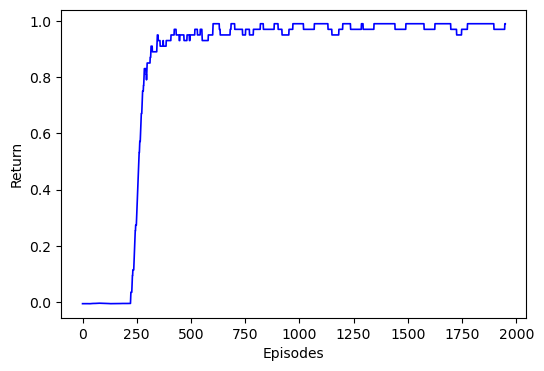

In [39]:
if not skip_training:
    plt.figure(figsize=(6, 4))
    plt.plot(avg_returns, linewidth=1.2, color='b')
    plt.xlabel('Episodes', fontsize=10)
    plt.ylabel('Return', fontsize=10)
    plt.show()

<a id='Q2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 2.</b> MCTS algorithm (5 points)</h3> 
<!-- Describe different phases in MCTS. Explain each one briefly in your own words. -->
Which statement is correct?
    
1. In MCTS, selection refers to choosing a random action for leaf nodes.
2. In MCTS, only Q values are used to make a decision.
3. In MCTS backpropagation step, nodes are updated from the root of the tree to the leaf nodes. 
4. In MCTS, simulation step is is used until reaching a leaf node
5. In MCTS selection step, unvisited nodes are always prioritized.

<br>
<br>
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

In [41]:
sq2 = 5  # replace ``None`` with your option

Do not remove or change the following cells, which are used for grading.

# 3. Submitting <a id='3.'></a>
Ensure all tasks and questions (in ```ex7_MCTS.ipynb```) are answered and the relevant plots are recorded in the relevant places. 

In [ ]:
# Make sure that skip training is set to True before submission
assert skip_training == True

## 3.1 Feedback <a id='3.1'></a>

In order to help the staff of the course as well as the forthcoming students, it would be great if you could answer to the following questions in your submission:

1) How much time did you spend solving this exercise? (change the ```hrs``` variable below to a floating point number representing the number of hours taken e.g. 5.43)


In [ ]:
hrs = None

2) Difficulty of each task/question from 1-5 (int or float)

In [ ]:
T1 = None # Student Task 1. Implementing MCTS
Q1 = None # Question 1.1: Difficulty of the task
Q2 = None # Question 2.1: MCTS phases

3) How well did you understand the content of the task/question from 1-5? (int or float)


In [ ]:
T1 = None # Student Task 1. Implementing MCTS
Q1 = None # Question 1.1: Difficulty of the task
Q2 = None # Question 2.1: MCTS phases

4) General feedback. Consider questions like:

    - Did the content of the lecture relate well with the assignment?
    - To what extent did you find the material to be potentially useful for your research and studies?
    
And other feedback you think is worth including. Type in the box below

Your feedback here.

Please use the following section to record references.
# References <a id='4.'></a>

